In [308]:
import praw

from praw.models import MoreComments

import nltk

import matplotlib

import re

from nltk.tokenize import word_tokenize

from nltk.tag import pos_tag

from nltk.chunk import ne_chunk

from nltk.corpus import stopwords

import pandas as pd

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words

from nltk.corpus import stopwords

import numpy as np

from itertools import chain

import datetime as dt

'''visual'''

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size

import seaborn as sns

sns.set(style='whitegrid', palette='Dark2')

from wordcloud import WordCloud

'''final plot'''

import random

import math

import copy

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt 

In [309]:
ci = "nmQIaN9L4keCTFTOFOoaTw" #your client id

cs = "ihneu8w8B1w5wQdNuPk7o2JVV0FFSg" #your client secret

ua = "iamcoolwolf" #your user agent name

sub = "news" #the name of the subreddit (not including the 'r/')

reddit = praw.Reddit(
    client_id=ci,
    client_secret=cs,
    user_agent=ua
)

In [310]:
def get_date(submission):
    
	time = submission.created
    
	return dt.datetime.fromtimestamp(time)

def get_comment_date(comment):
    
	time = comment.created
    
	return dt.datetime.fromtimestamp(time)

In [340]:
data = []

for post in reddit.subreddit(sub).hot(limit=1000):
    
    data.append({
        'id': post.id,
        'title': post.title,
#         'text': post.selftext,
        'date': get_date(post),
        'score': post.score,
#         'comments': post.comments
    })
    
    for comment in post.comments:
            
        if isinstance(comment, MoreComments):
            
            continue
                
        data.append({'comments': str(comment.body) + '\n',
                     
                    'comments_time': get_comment_date(post)})

In [341]:
df = pd.DataFrame(data)

In [342]:
sid = SentimentIntensityAnalyzer()

pos_text = "Vader is awesome"

cap_pos_text = "Vader is AWESOME!" # captilization and ! increases the effect

neg_text = "Vader is bad"

print(sid.polarity_scores(pos_text))

print(sid.polarity_scores(cap_pos_text))

print(sid.polarity_scores(neg_text))

{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.729}
{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}


## comments sentiments

In [343]:

# res = [*df['comments'].apply(sid.polarity_scores)]

# print(res[:3])

df_comment = df['comments']

In [344]:
df_comment = pd.DataFrame(df_comment)

df_sentence = []

for comment in df_comment.comments:
    
    df_sentence.append({
#         'text_tokens': nltk.word_tokenize(str(comment)),
#         'text_lowercase': [t.lower() for t in nltk.word_tokenize(str(comment))],
# #         'text': post.selftext,
#         'text_no_punct': [t for t in [t.lower() for t in nltk.word_tokenize(str(comment))] if t.isalnum()],
        'sentence': ' '.join([t for t in [t.lower() for t in nltk.word_tokenize(str(comment))] if t.isalnum()])
    })
    
#     df_sentence.append()
    
#     text_tokens = nltk.word_tokenize(str(comment))
    
#     text_lowercase = [t.lower() for t in text_tokens]

#     '''removing punctuation'''

#     text_no_punct = [t for t in text_lowercase if t.isalnum()]
    
#     sentence = ' '.join(text_no_punct)

df_sentence_data = pd.DataFrame(df_sentence)
    
df_sentence_data.head()

,sentence
0,nan
1,that a weird way of saying she raped a child a...
2,i hope the da loses their job over this this i...
3,wtf we sentence people to jail for far less sh...
4,she was 31 male child was 13 this is messed up


In [345]:
res = [*df_sentence_data['sentence'].apply(sid.polarity_scores)]

print(res[:3])

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.458, 'neu': 0.542, 'pos': 0.0, 'compound': -0.8519}, {'neg': 0.124, 'neu': 0.538, 'pos': 0.339, 'compound': 0.6124}]


In [346]:
sentiment_df = pd.DataFrame.from_records(res)

comment_data = pd.concat([df_sentence_data, sentiment_df], axis=1, join='inner')

comment_data.head()



,sentence,neg,neu,pos,compound
0,nan,0.000,1.000,0.000,0.0000
1,that a weird way of saying she raped a child a...,0.458,0.542,0.000,-0.8519
2,i hope the da loses their job over this this i...,0.124,0.538,0.339,0.6124
3,wtf we sentence people to jail for far less sh...,0.332,0.607,0.061,-0.7783
4,she was 31 male child was 13 this is messed up,0.194,0.806,0.000,-0.3400


In [347]:
conditions = [
    
    (comment_data['compound'] <= -0.2),
    
    (comment_data['compound'] > -0.2) & (comment_data['compound'] < 0.2),
    
    (comment_data['compound'] >= 0.2),
    ]

values = ["neg", "neu", "pos"]

comment_data['comment_label'] = np.select(conditions, values)

comment_data.head()

# data.to_csv('sentiment_sentence.csv')

,sentence,neg,neu,pos,compound,comment_label
0,nan,0.000,1.000,0.000,0.0000,neu
1,that a weird way of saying she raped a child a...,0.458,0.542,0.000,-0.8519,neg
2,i hope the da loses their job over this this i...,0.124,0.538,0.339,0.6124,pos
3,wtf we sentence people to jail for far less sh...,0.332,0.607,0.061,-0.7783,neg
4,she was 31 male child was 13 this is messed up,0.194,0.806,0.000,-0.3400,neg


<AxesSubplot:xlabel='comment_label', ylabel='Count'>

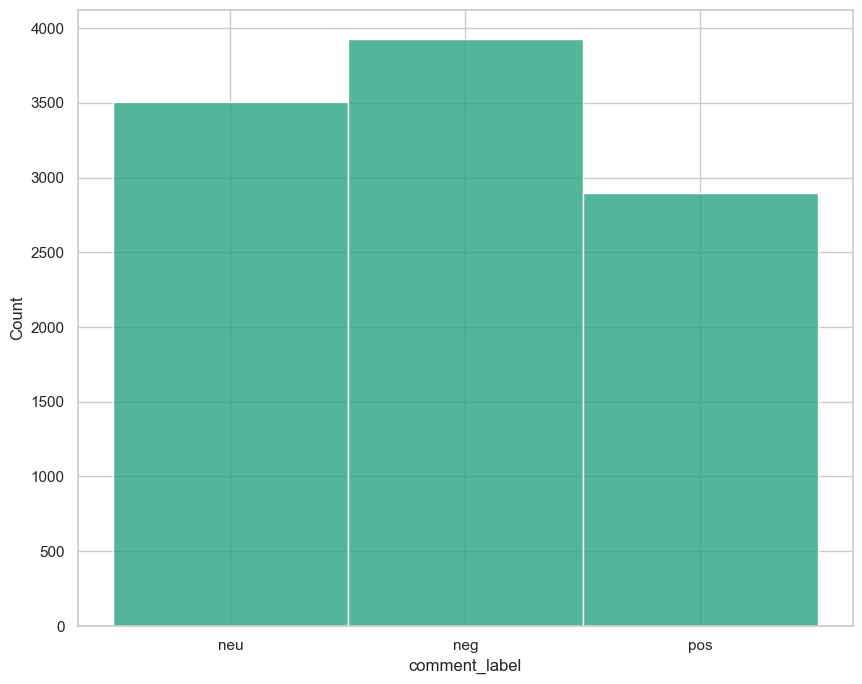

In [348]:
# comment_count = comment_data.comment_label.value_counts()

comment_count = comment_data.dropna(subset=['sentence']).reset_index(drop=True).comment_label.value_counts()
'''plot'''

# sns.set(style='whitegrid', palette='Dark2')

sns.histplot(comment_data.dropna(subset=['sentence']).reset_index(drop=True).comment_label)

In [431]:
'''lexical'''
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [406]:
comment_count

neg    3925
neu    3508
pos    2898
Name: comment_label, dtype: int64

## frequency analysis of comments

In [412]:
"""freqency of words in comments"""

with open('comments_words'+".txt", "w") as f:

    for sentence in comment_data.sentence:
        
        f.write(sentence)
    
    
'''load file'''

text_name = 'comments_words' + '.txt'

def load_txt(file):
    
    with open(file, encoding='utf8') as f:
        
        return ' '.join(line.strip() for line in f.readlines())
    
text_comments = load_txt(text_name)

'''frequency distribution of words'''

# text_tokens = nltk.word_tokenize(text)

# tagged = nltk.pos_tag(text_tokens)

# fd = nltk.FreqDist(text for (text_tokens, pos) in tagged if pos == 'NN')

# # fd = nltk.FreqDist(text_no_stop)

# print(fd.most_common(60))

# '''plot the frequency distribution'''

# fd.plot(60)

'frequency distribution of words'

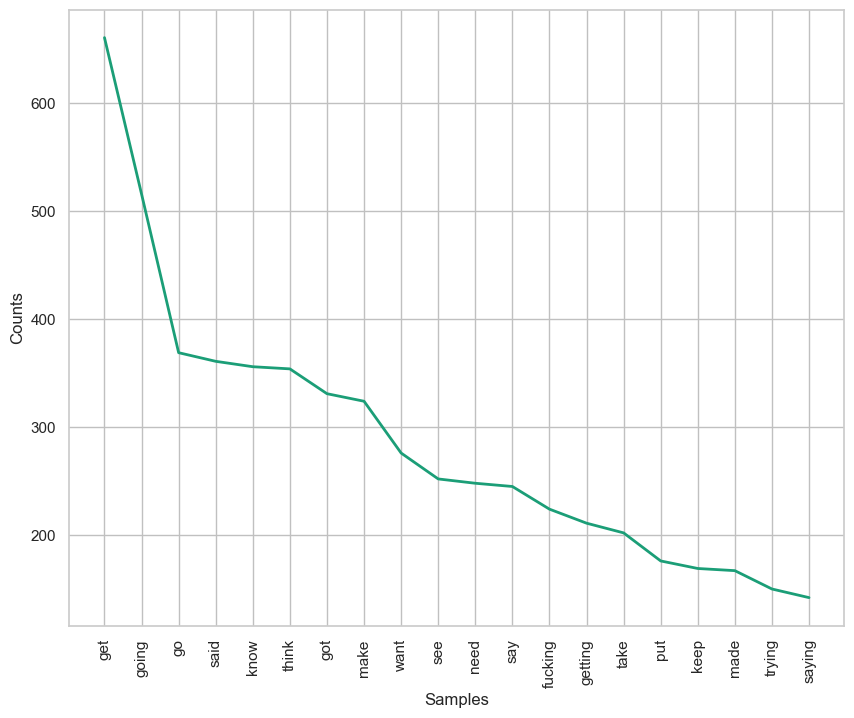

[('get', 661), ('going', 516), ('go', 369), ('said', 361), ('know', 356), ('think', 354), ('got', 331), ('make', 324), ('want', 276), ('see', 252), ('need', 248), ('say', 245), ('fucking', 224), ('getting', 211), ('take', 202), ('put', 176), ('keep', 169), ('made', 167), ('trying', 150), ('saying', 142), ('let', 132), ('used', 131), ('seems', 130), ('making', 120), ('gets', 119), ('makes', 119), ('believe', 114), ('thought', 112), ('left', 106), ('done', 103), ('says', 100), ('give', 99), ('took', 97), ('shit', 97), ('feel', 96), ('find', 96), ('hope', 95), ('went', 93), ('happened', 93), ('taking', 89), ('working', 87), ('come', 85), ('found', 84), ('stop', 83), ('told', 83), ('pay', 82), ('using', 80), ('seen', 80), ('paid', 80), ('called', 79)]


In [438]:
'''frequency distribution of words'''

comment_text_tokens = nltk.word_tokenize(text_comments)

comment_text_lowercase = [t.lower() for t in comment_text_tokens]

comment_text_no_punct = [t for t in text_lowercase if t.isalnum()]

comment_text_no_stop = [t for t in comment_text_tokens if t not in stopwords.words('english')]

tagged = nltk.pos_tag(comment_text_no_stop)

# fd_comments = nltk.FreqDist(comment_text_no_stop for (comment_text_no_stop, pos) in tagged if 'NN' in pos )

# fd_comments = nltk.FreqDist(comment_text_no_stop)

fd_comments = nltk.FreqDist(comment_text_no_stop for (comment_text_no_stop, pos) in tagged if 'V' in pos )

fd_comments_words = (fd_comments.most_common(50))

# '''plot'''

fd_comments.plot(20)

print(fd_comments_words)


In [440]:
"""lexical"""

lexical_diversity(comment_text_no_stop)

0.17901398827717646

In [478]:
text_comments

'nanthat a weird way of saying she raped a child and forced him to become a parenti hope the da loses their job over this this is a miscarriage of justicewtf we sentence people to jail for far less she should be spending years in prisonshe was 31 male child was 13 this is messed upjustice failed this childwhy the fuck did they need a plea deal do a genetic test of the baby bam proof they had sex take that shit to courti feel like if she was a man and he was a little girl it would definitely be different i think everyone here knows that would be the caseno jail time for woman who admitted sex raping a having his baby there ftfyand she has edit incels please stop bitching about women in my mentions women aren t evil and it s not their fault you re lonelyi know it sucks for the baby and it s not their fault but this 13 year old should never have to pay child supportno jail time for female pedophile there fixed the titlebetween this and that pastor who got off easy while raping his 10 year

In [482]:
comments_words.dispersion_plot(["get", "going"])

NameError: name 'comments_words' is not defined

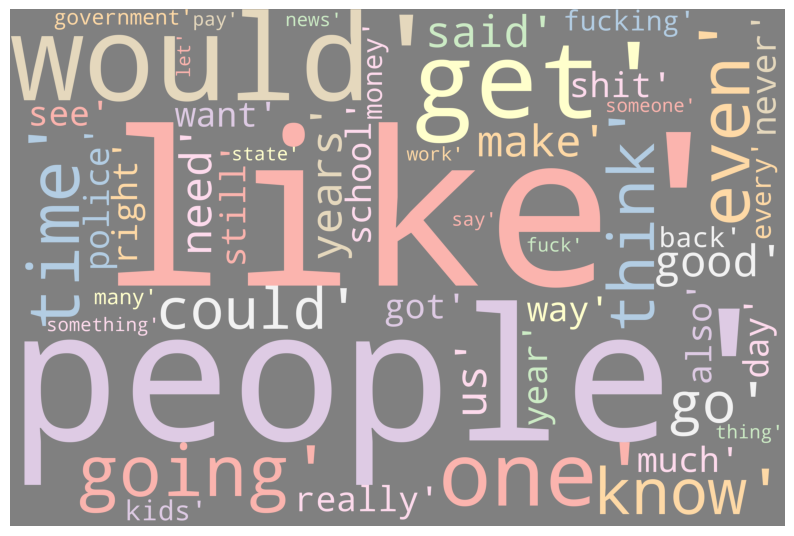

In [422]:
'''word cloud'''

word_cloud = WordCloud(
    width=3000,
    height=2000,
    random_state=1,
    background_color="grey"
    ,
    colormap="Pastel1"
    ,
    collocations=False).generate(str(fd_comments_words[:]))

plt.imshow(word_cloud)

plt.axis("off")

plt.show()

In [353]:
# '''which word is negative'''

# sentence0 = df_sentence_data.sentence.iloc[0]
# print(sentence0)
# words0 = df_sentence_data.sentence.iloc[0].split()
# print(words0)

# pos_list, neg_list, neu_list = [], [], []

# for word in words0:
#   if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
#     pos_list.append(word)
#   elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
#     neg_list.append(word)
#   else:
#     neu_list.append(word)                

# print('\nPositive:',pos_list)        
# print('Neutral:',neu_list)    
# print('Negative:',neg_list) 
# score = sid.polarity_scores(sentence0)

# print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
# print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
# print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")
# print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
# print(f"\nThis sentence is NEGATIVE")

In [354]:
'''print the possitive and negative words according to titles'''

# stop_words = stopwords.words('english')

# def custom_tokenize(text):
    
#   # remove single quote and dashes

#     text = text.replace("'", "").replace("-", "").lower()
    
    

#   # split on words only

#     tk = nltk.tokenize.RegexpTokenizer(r'\w+')
    
#     tokens = tk.tokenize(text)

#   # remove stop words
    
#     words = [w for w in tokens if not w in stop_words]

#     return words

# print(custom_tokenize(post.comments))

'print the possitive and negative words according to titles'

In [355]:
# def tokens_2_words(df, label):
#   # subset titles based on label
#   sentence = df[df['comment_label'] == label].comment_label
#   # apply our custom tokenize function to each title
#   tokens = sentence.apply(custom_tokenize)
#   # join nested lists into a single list
#   words = list(chain.from_iterable(tokens))
#   return words

# pos_words = tokens_2_words(comment_data, 'pos')
# neg_words = tokens_2_words(comment_data, 'neg')

In [356]:
# """positive words"""

# pos_freq = nltk.FreqDist(pos_words)

# pos_freq.most_common(20)[:]

In [357]:
# word_cloud = WordCloud(
#     width=3000,
#     height=2000,
#     random_state=1,
#     background_color="grey"
#     ,
#     colormap="Pastel1"
#     ,
#     collocations=False).generate(str(pos_freq.most_common(60)[3:]))

# plt.imshow(word_cloud)

# plt.axis("off")

# plt.show()

In [358]:
# """negative words"""

# pos_freq = nltk.FreqDist(neg_words)

# pos_freq.most_common(20)

In [359]:
# word_cloud = WordCloud(
#     width=3000,
#     height=2000,
#     random_state=1,
#     background_color="white"
#     ,
#     colormap="RdYlGn"
#     ,
#     collocations=False).generate(str(pos_words))

# plt.imshow(word_cloud)

# plt.axis("off")

# plt.show()

## title sentiments analysis

In [381]:
df_title = df['title']

df_title = pd.DataFrame(df_title)

df_title_sent = []

for title in df_title.title:
    
    df_title_sent.append({
#         'text_tokens': nltk.word_tokenize(str(comment)),
#         'text_lowercase': [t.lower() for t in nltk.word_tokenize(str(comment))],
# #         'text': post.selftext,
#         'text_no_punct': [t for t in [t.lower() for t in nltk.word_tokenize(str(comment))] if t.isalnum()],
        'title_sent': ' '.join([t for t in [t.lower() for t in nltk.word_tokenize(str(title))] if t.isalnum()])
    })
    
#     df_sentence.append()
    
#     text_tokens = nltk.word_tokenize(str(comment))
    
#     text_lowercase = [t.lower() for t in text_tokens]

#     '''removing punctuation'''

#     text_no_punct = [t for t in text_lowercase if t.isalnum()]
    
#     sentence = ' '.join(text_no_punct)

df_title_data = pd.DataFrame(df_title_sent)
    
df_title_data.head()



,title_sent
0,no jail time for woman who admitted having sex...
1,nan
2,nan
3,nan
4,nan


In [382]:
res = [*df_title_data['title_sent'].apply(sid.polarity_scores)]

print(res[:3])

sentiment_df = pd.DataFrame.from_records(res)

title_data = pd.concat([df, sentiment_df], axis=1, join='inner')

title_data.head()

[{'neg': 0.151, 'neu': 0.753, 'pos': 0.096, 'compound': -0.2023}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]


,id,title,date,score,comments,comments_time,neg,neu,pos,compound
0,11h8p9p,No jail time for woman who admitted having sex...,2023-03-03 17:54:04,22499.0,NaN,NaT,0.151,0.753,0.096,-0.2023
1,NaN,NaN,NaT,NaN,That's a weird way of saying she raped a child...,2023-03-03 17:54:04,0.000,1.000,0.000,0.0000
2,NaN,NaN,NaT,NaN,I hope the DA loses their job over this. This...,2023-03-03 17:54:04,0.000,1.000,0.000,0.0000
3,NaN,NaN,NaT,NaN,Wtf we sentence people to jail for far less. S...,2023-03-03 17:54:04,0.000,1.000,0.000,0.0000
4,NaN,NaN,NaT,NaN,"She was 31, male child was 13, this is messed ...",2023-03-03 17:54:04,0.000,1.000,0.000,0.0000


In [383]:
THRESHOLD = 0.2

conditions = [
    (title_data['compound'] <= -THRESHOLD),
    (title_data['compound'] > -THRESHOLD) & (title_data['compound'] < THRESHOLD),
    (title_data['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]

title_data['title_label'] = np.select(conditions, values)

title_data.head()

# data.to_csv('sentiment_sentence.csv')

,id,title,date,score,comments,comments_time,neg,neu,pos,compound,title_label
0,11h8p9p,No jail time for woman who admitted having sex...,2023-03-03 17:54:04,22499.0,NaN,NaT,0.151,0.753,0.096,-0.2023,neg
1,NaN,NaN,NaT,NaN,That's a weird way of saying she raped a child...,2023-03-03 17:54:04,0.000,1.000,0.000,0.0000,neu
2,NaN,NaN,NaT,NaN,I hope the DA loses their job over this. This...,2023-03-03 17:54:04,0.000,1.000,0.000,0.0000,neu
3,NaN,NaN,NaT,NaN,Wtf we sentence people to jail for far less. S...,2023-03-03 17:54:04,0.000,1.000,0.000,0.0000,neu
4,NaN,NaN,NaT,NaN,"She was 31, male child was 13, this is messed ...",2023-03-03 17:54:04,0.000,1.000,0.000,0.0000,neu


neg    178
neu     85
pos     26
Name: title_label, dtype: int64


<AxesSubplot:xlabel='title_label', ylabel='Count'>

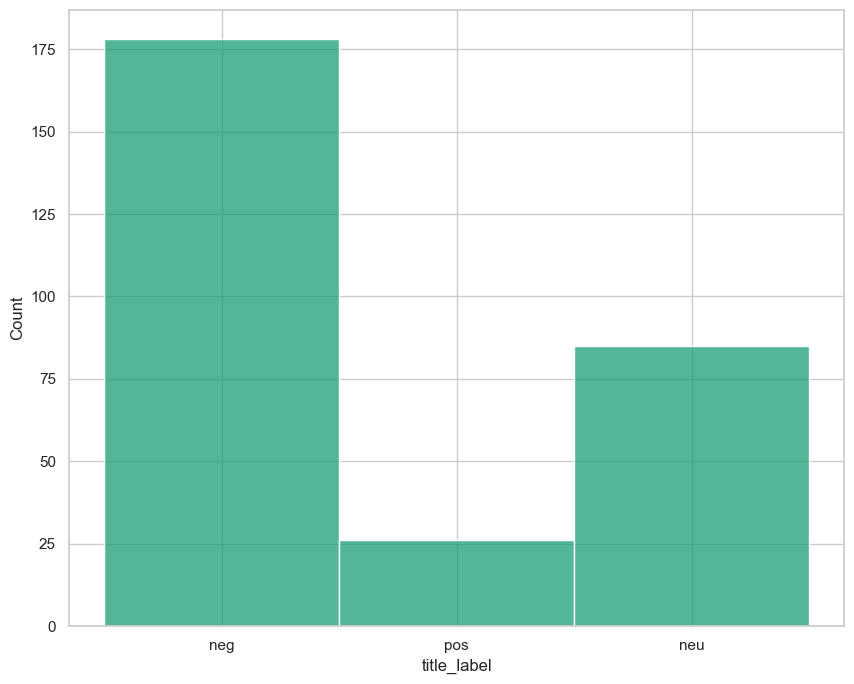

In [384]:

# Drop rows that has NaN values on selected columns
title_count=title_data.dropna(subset=['title']).reset_index(drop=True).title_label.value_counts()

print(title_count)

# '''plot'''

# sns.set(style='whitegrid', palette='Dark2')

sns.histplot(title_data.dropna(subset=['title']).reset_index(drop=True).title_label)

## frequency analysis of title

In [459]:
"""freqency of words in title"""

title_clean_data = title_data.dropna(subset=['title']).reset_index(drop=True)

with open('title_words'+".txt", "w") as f:

    for word in title_clean_data.title:
        
        f.write(word)
    
    
'''load file'''

text_name = 'title_words' + '.txt'

def load_txt(file):
    
    with open(file, encoding='utf8') as f:
        
        return ' '.join(line.strip() for line in f.readlines())
    
text_title = load_txt(text_name)

'''frequency distribution of words'''

# text_tokens = nltk.word_tokenize(text)

# tagged = nltk.pos_tag(text_tokens)

# fd = nltk.FreqDist(text for (text_tokens, pos) in tagged if pos == 'NN')

# # fd = nltk.FreqDist(text_no_stop)

# print(fd.most_common(60))

# '''plot the frequency distribution'''

# fd.plot(60)

'frequency distribution of words'

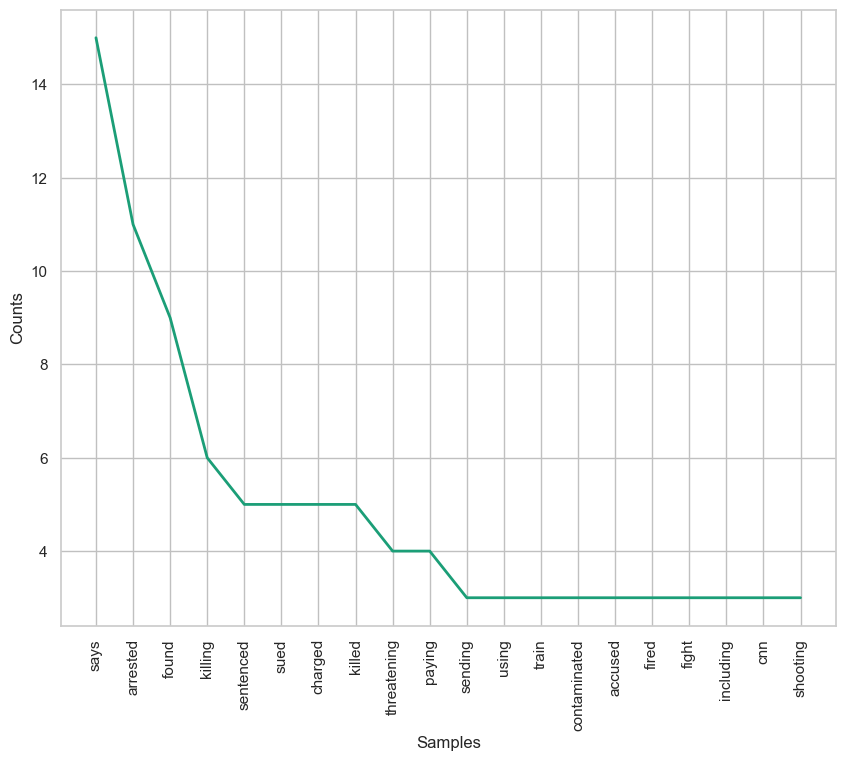

[('says', 15), ('arrested', 11), ('found', 9), ('killing', 6), ('sentenced', 5), ('sued', 5), ('charged', 5), ('killed', 5), ('threatening', 4), ('paying', 4), ('sending', 3), ('using', 3), ('train', 3), ('contaminated', 3), ('accused', 3), ('fired', 3), ('fight', 3), ('including', 3), ('cnn', 3), ('shooting', 3), ('removed', 2), ('stranded', 2), ('ohio', 2), ('tied', 2), ('sent', 2), ('dies', 2), ('russia', 2), ('cleaning', 2), ('left', 2), ('facing', 2), ('alleged', 2), ('confirmed', 2), ('died', 2), ('commits', 2), ('fed', 2), ('find', 2), ('agrees', 2), ('pay', 2), ('warns', 2), ('making', 2), ('set', 2), ('leading', 2), ('caused', 2), ('lose', 2), ('setting', 2), ('taken', 2), ('missing', 2), ('investigating', 2), ('poisoning', 2), ('stolen', 2), ('takes', 2), ('oks', 2), ('creator', 2), ('reported', 2), ('say', 2), ('paid', 2), ('remains', 2), ('trying', 2), ('admitted', 1), ('advise', 1), ('get', 1), ('states', 1), ('banned', 1), ('running', 1), ('end', 1), ('pregnancyleaked', 1

In [460]:
'''frequency distribution of words'''

text_tokens = nltk.word_tokenize(text_title)

text_lowercase = [t.lower() for t in text_tokens]

text_no_punct = [t for t in text_lowercase if t.isalnum()]

text_no_stop = [t for t in text_no_punct if t not in stopwords.words('english')]

tagged = nltk.pos_tag(text_no_stop)

fd = nltk.FreqDist(text_no_stop for (text_no_stop, pos) in tagged if 'NN' in pos )

# fd = nltk.FreqDist(text_no_stop)

# fd = nltk.FreqDist(text_no_stop)

fd_title_words = (fd.most_common(90))

'''plot'''

fd.plot(20)

print(fd_title_words)

In [461]:
'''lexical'''
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [462]:
lexical_diversity(text_no_stop)

0.7155883630047764

## combine title and comments

In [387]:
title_data['comment_label'] = comment_data['comment_label']

title_data = title_data[['title', 'comments', 'title_label', 'comment_label']]

title_data.to_csv('combined_data.csv')

title_data.dropna(subset=['title']).reset_index(drop=True).to_csv('title.csv')

# plot line plot

In [368]:
'''data'''

df=pd.read_csv('combined_data.csv')

df=df.drop(columns=['Unnamed: 0'])

df

s_idx=0

idx=0

count=0

while idx<len(df):
    
    if not pd.isna(df.title.iloc[idx]) or idx == len(df)-1:
        
        sub_df=df.iloc[s_idx:idx]
        
        if len(sub_df)>0:
            
            count+=1
            
            sub_df=sub_df.reset_index(drop=True)
            
            sub_df.to_csv('title'+str(count)+'.csv')

        s_idx=idx

    idx+=1

In [ ]:
'''plot'''

Stat_df=pd.DataFrame([],columns=['neg','neu','pos'])

for idx in range(1,count+1,1):

    sub_df=pd.read_csv('title'+str(idx)+'.csv')

    stat_df=sub_df.iloc[1:].groupby('comment_label').count()
    
    stat_df=stat_df[['comments']]
    
    stat_df['ratio']=100*stat_df.comments/stat_df.comments.sum()
    
    stat_dic={'neg':0,'neu':0,'pos':0}
    
    for idx_,row in stat_df.iterrows():
        
        stat_dic[idx_]=row.ratio
        
    Stat_df = Stat_df.append(stat_dic, ignore_index=True)

    
font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

font_title = {'family' : 'Arial','weight' : 'normal','size': 20}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

fig, axs = plt.subplots(figsize = (20,5))

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

axs.grid()

axs.plot(Stat_df.neg, linestyle='--',linewidth=2,color='red',label='negative')

axs.plot(Stat_df.neu, linestyle='--',linewidth=2,color='blue',label='neutral')

axs.plot(Stat_df.pos, linestyle='--',linewidth=2,color='green',label='positive')


axs.set_xlabel('titles',font_label)

axs.set_ylabel('percentahe(%)',font_label)

axs.legend(loc='center', bbox_to_anchor=(0.5, 1.1), prop=font_title,ncol=4)


plt.show()